## Importing All Required Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import time
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from keras_tuner import RandomSearch
# import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline
import pytz

## Importing Dataset i.e. Nabil Bank (nabil) Stock Price Dataset

In [20]:
df = pd.read_csv('/content/drive/MyDrive/MSc. Dissertation/Dataset/nabil.csv')

In [21]:
df.head()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
0,3/20/2011,"1,200.00","1,190.00","1,160.00","1,170.00",0.0,853,"1,000,811.00"
1,3/24/2011,"1,162.00","1,178.00","1,150.00","1,153.00",0.0,356,"412,649.00"
2,3/25/2011,"1,153.00","1,174.00","1,145.00","1,174.00",0.0,702,"807,507.00"
3,3/27/2011,"1,174.00","1,160.00","1,120.00","1,147.00",0.0,"1,426.00","1,619,270.00"
4,3/28/2011,"1,147.00","1,150.00","1,110.00","1,132.00",0.0,352,"393,534.00"


In [22]:
df.tail()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
3078,9/18/2024,562,565,550,556,-0.93,"68,886.00","38,431,118.40"
3079,9/22/2024,556,578,556,562,1.08,"55,026.00","31,054,968.70"
3080,9/23/2024,573.2,573.2,555,568,1.07,"123,568.00","69,577,465.00"
3081,9/24/2024,567,567,552.1,553.5,-2.55,"66,337.00","36,962,336.00"
3082,9/25/2024,550,560,545.1,555,0.27,"50,441.00","27,867,328.70"


In [23]:
df.duplicated().sum()

1

## Copying the dataset for future use

In [24]:
df1 = df.copy()
df1.reset_index(inplace=True)

### Renaming and Dropping unwanted column

In [25]:
df.drop(['% Change', 'Turnover'], axis=1, inplace=True)
df = df.rename(columns = {
    'Ltp': 'Close',
    'Qty': 'Volume'
})

In [26]:
df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float).astype(int)
df

,Date,Open,High,Low,Close,Volume
0,2011-03-20,1200.0,1190.0,1160.0,1170.0,853
1,2011-03-24,1162.0,1178.0,1150.0,1153.0,356
2,2011-03-25,1153.0,1174.0,1145.0,1174.0,702
3,2011-03-27,1174.0,1160.0,1120.0,1147.0,1426
4,2011-03-28,1147.0,1150.0,1110.0,1132.0,352
...,...,...,...,...,...,...
3078,2024-09-18,562.0,565.0,550.0,556.0,68886
3079,2024-09-22,556.0,578.0,556.0,562.0,55026
3080,2024-09-23,573.2,573.2,555.0,568.0,123568
3081,2024-09-24,567.0,567.0,552.1,553.5,66337


### Splitting into features and target

In [27]:
features = df[['Open', 'High', 'Low', 'Volume']]
target = df[['Close']]

### Scaling the features

In [28]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale the features (Open, High, Low, Volume)
scaled_features = scaler_features.fit_transform(features)

# Scale the target (Close)
scaled_target = scaler_target.fit_transform(target)

### Convert to DataFrame to maintain indices

In [29]:
# Combine the scaled features and scaled target into a new DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=['Open', 'High', 'Low', 'Volume'])
scaled_data['Close'] = scaled_target  # Use the scaled Close values as the target

### Function to create sequences

In [30]:
sequence_length = 30
X = []
y = []
target_index = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[['Open', 'High', 'Low', 'Volume']].values[i-sequence_length:i])
    y.append(scaled_data['Close'].values[i])
    target_index.append(i)  # store index of each target value

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

### Splitting the data into train and test set

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, y_test_indices = train_test_split(target_index, test_size=0.2, random_state=42)

### Model Building using CNN-LSTM


In [32]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

In [33]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# 4. Train the Model
start = time.time()
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)
end = time.time()
print('Training Time:', end - start)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0159 - mae: 0.0794 - mse: 0.0159 - val_loss: 0.0019 - val_mae: 0.0292 - val_mse: 0.0019
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0040 - mae: 0.0444 - mse: 0.0040 - val_loss: 0.0012 - val_mae: 0.0240 - val_mse: 0.0012
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0035 - mae: 0.0402 - mse: 0.0035 - val_loss: 9.4193e-04 - val_mae: 0.0202 - val_mse: 9.4193e-04
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0031 - mae: 0.0374 - mse: 0.0031 - val_loss: 7.6869e-04 - val_mae: 0.0179 - val_mse: 7.6869e-04
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0027 - mae: 0.0355 - mse: 0.0027 - val_loss: 0.0011 - val_mae: 0.0221 - val_mse: 0.0011
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0027 - mae: 0.0349 - mse: 0.0027 - val_loss: 0.0014 - val_mae: 0.0267 - val_mse: 0.0014
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0025 - mae: 0.0

In [34]:
# Make predictions on the test set
predictions = model.predict(X_test)
predictions.flatten()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([0.4447658 , 0.6787784 , 0.5445461 , 0.69537354, 0.09606232,
       0.36952692, 0.5782783 , 0.41040188, 0.6102114 , 0.42283794,
       0.4658183 , 0.0783208 , 0.34402904, 0.4571046 , 0.6567601 ,
       0.17933513, 0.8151856 , 0.3510409 , 0.19266857, 0.8274998 ,
       0.18581368, 0.12872343, 0.5565576 , 0.43867913, 0.7612655 ,
       0.19545938, 0.081763  , 0.23478264, 0.44068646, 0.13562182,
       0.9184333 , 0.61627936, 0.18400282, 0.4343069 , 0.6391486 ,
       0.23475792, 0.07376894, 0.81405616, 0.18850298, 0.15795834,
       0.26069203, 0.03738636, 0.47863382, 0.1495506 , 0.01301917,
       0.1413152 , 0.31963325, 0.2813791 , 0.36266845, 0.5769479 ,
       0.18534233, 0.5262064 , 0.4320109 , 0.36957443, 0.5436069 ,
       0.07106757, 0.04411945, 0.37850574, 0.2714552 , 0.26001024,
       0.65553546, 0.67018986, 0.37932622, 0.5483175 , 0.19604294,
       0.91417444, 0.02519774, 0.07079473, 0.30258203, 0.38504156,
       0.6621956 , 0.6413104 , 0.15193339, 0.43468896, 0.20810

In [35]:
y_test

array([0.45017182, 0.66709622, 0.55841924, 0.70575601, 0.09965636,
       0.3685567 , 0.57689003, 0.43939003, 0.5854811 , 0.45532646,
       0.48281787, 0.07310997, 0.33934708, 0.45446735, 0.67353952,
       0.17310997, 0.79381443, 0.34750859, 0.1911512 , 0.80670103,
       0.1774055 , 0.12628866, 0.5661512 , 0.43685567, 0.73152921,
       0.19802405, 0.09750859, 0.22680412, 0.43513746, 0.14175258,
       0.96993127, 0.62414089, 0.18170103, 0.44158076, 0.62285223,
       0.22379725, 0.08891753, 0.81099656, 0.18213058, 0.14067869,
       0.24699313, 0.0270189 , 0.48883162, 0.14390034, 0.00558419,
       0.12843643, 0.31357388, 0.27405498, 0.36297251, 0.5790378 ,
       0.18427835, 0.53221649, 0.43599656, 0.37457045, 0.54080756,
       0.08118557, 0.04338488, 0.37628866, 0.28264605, 0.24140893,
       0.64561856, 0.64561856, 0.36984536, 0.55541237, 0.19630584,
       0.9871134 , 0.01159794, 0.05992268, 0.29424399, 0.39003436,
       0.66065292, 0.65120275, 0.14304124, 0.43857388, 0.20833

In [36]:
y_pred_inv = scaler_target.inverse_transform(predictions)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

In [37]:
prediction = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Predicted': y_pred_inv.flatten()}, index=y_test_indices)
for a in prediction.index:
    for b in df.index:
        if a == b:
            prediction['Date'] = df['Date']
prediction.set_index('Date', inplace=True)
prediction.sort_index(inplace=True)
prediction

,Actual,Predicted
Date,,
2011-05-11,1070.0,1062.070435
2011-06-02,1056.0,1118.249878
2011-06-14,868.0,973.843872
2011-06-26,1228.0,1233.887939
2011-06-27,1106.0,1314.691284
...,...,...
2024-09-01,595.0,636.638672
2024-09-09,573.0,599.871887
2024-09-11,561.5,586.810120


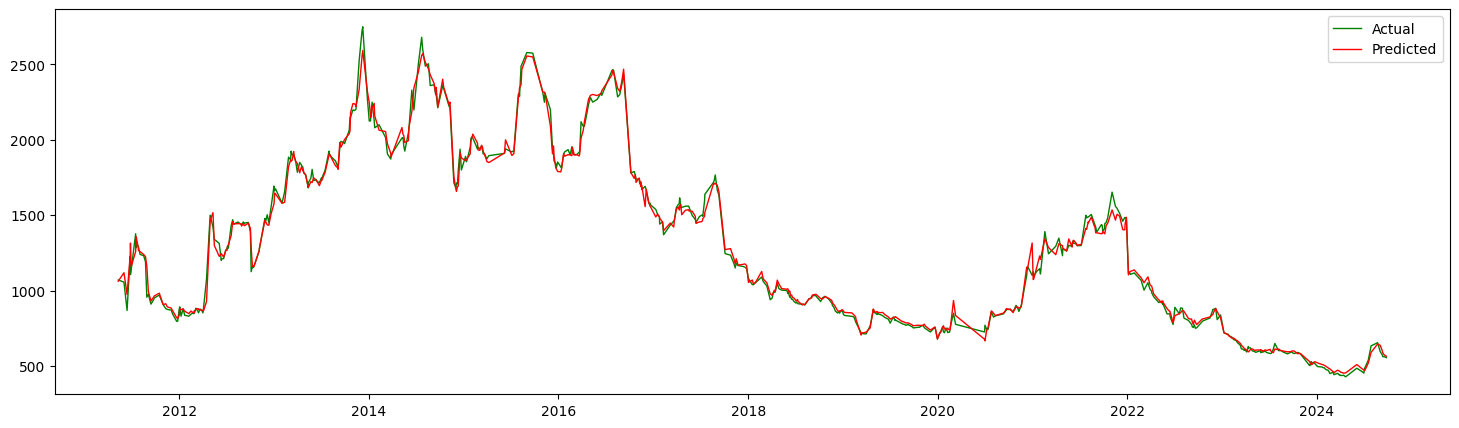

In [38]:
plt.figure(figsize=(18, 5))
plt.plot(prediction.Actual, label='Actual', color='g', linewidth=1)
plt.plot(prediction.Predicted, label='Predicted', color='r', linewidth=1)
plt.legend()
plt.show()


## Calculating the Performance Evaluation Metrics

In [39]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 0.0003050978636459712
Root Mean Squared Error: 0.017467050799890953
Mean Absolute Error: 0.011603194377504008


In [40]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 1653.5033540128225
Root Mean Squared Error: 40.663292464000286
Mean Absolute Error: 27.012232693985908
